# Importing the require labrary

In [85]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2

from sklearn.metrics import classification_report, confusion_matrix

import os

import warnings
warnings.filterwarnings('ignore')

ntroduction
In this notobook, I tried to classify Dog and Cat images by using MobileNet.

cat-dog.png

image from https://blogs.sas.com/content/subconsciousmusings/2017/09/25/machine-learning-concepts-styles-machine-learning/

According to the article "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications" by Cornell University,

MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. We introduce two simple global hyper-parameters that efficiently trade off between latency and accuracy. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem. We present extensive experiments on resource and accuracy tradeoffs and show strong performance compared to other popular models on ImageNet classification. We then demonstrate the effectiveness of MobileNets across a wide range of applications and use cases including object detection, finegrain classification, face attributes and large scale geo-localization.

I tried MobileNetV2 and V3. But V3 did not work well for some reason.... So this time, I used MobileNetV2.

reference:

"MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications" by Cornell University (https://arxiv.org/abs/1704.04861)
"Real vs Fake face detection" by DEBASIS SAMAL ( https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection )
'Transfer Learning - Image Classification + Deploy' by YASH SHAH ( https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy
"Building A Multiclass Image Classifier Using MobilenetV2 and TensorFlow" (https://www.section.io/engineering-education/building-a-multiclass-image-classifier-using-mobilenet-v2-and-tensorflow/)

#Code by 'Transfer Learning - Image Classification + Deploy' https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy
train_dir = "/kaggle/input/new-data-set-123/dogvscat/train"
train_class=os.listdir(train_dir)
print(train_class)


test_dir = "/kaggle/input/new-data-set-123/dogvscat/test"
test_class=os.listdir(test_dir)
print(test_class)

In [88]:
#Code by 'Transfer Learning - Image Classification + Deploy' https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy

x=[] # array value of the images
y=[] # the labels of the images

for folder in os.listdir(train_dir):
    image_list=os.listdir(train_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        img=image.img_to_array(img)
        
        # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
        img=preprocess_input(img)
        
        x.append(img) # appending image array
        y.append(train_class.index(folder)) # appending class index to the array
        
print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [89]:
#Code by 'Transfer Learning - Image Classification + Deploy' https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy
test_images=[]
test_images_Original=[]
test_image_label=[]

for folder in os.listdir(test_dir):
    image_list=os.listdir(test_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(test_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        
        # Converting to arrarys
        img=image.img_to_array(img)
        
        # Saving original images, will be used just for display at the end
        test_images_Original.append(img.copy())
        img=preprocess_input(img) 
        
        # Appending arrays
        test_images.append(img)
        test_image_label.append(test_class.index(folder))

print("Preparing Test Dataset Completed.")

Preparing Test Dataset Completed.


In [90]:
#Code by 'Transfer Learning - Image Classification + Deploy' https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy
# Training Dataset
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

print("Test Dataset")

test_images=np.array(test_images) 
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)


Training Dataset
(500, 224, 224, 3)
(500, 2)
Test Dataset
(50, 224, 224, 3)
(50, 2)


In [91]:
#Code by 'Transfer Learning - Image Classification + Deploy' https://www.kaggle.com/code/yash161101/transfer-learning-image-classification-deploy

xtrain, xval, ytrain, yval = train_test_split(x,y,test_size=0.2,random_state=5)
print("Splitting data for train and val completed.")

Splitting data for train and val completed.


# Sample Images

In [105]:
rand_images1 = random.sample(os.listdir("/kaggle/input/new-data-set-123/dogvscat/train/dog"), 8)
rand_images2 = random.sample(os.listdir("/kaggle/input/new-data-set-123/dogvscat/train/cat"), 8)

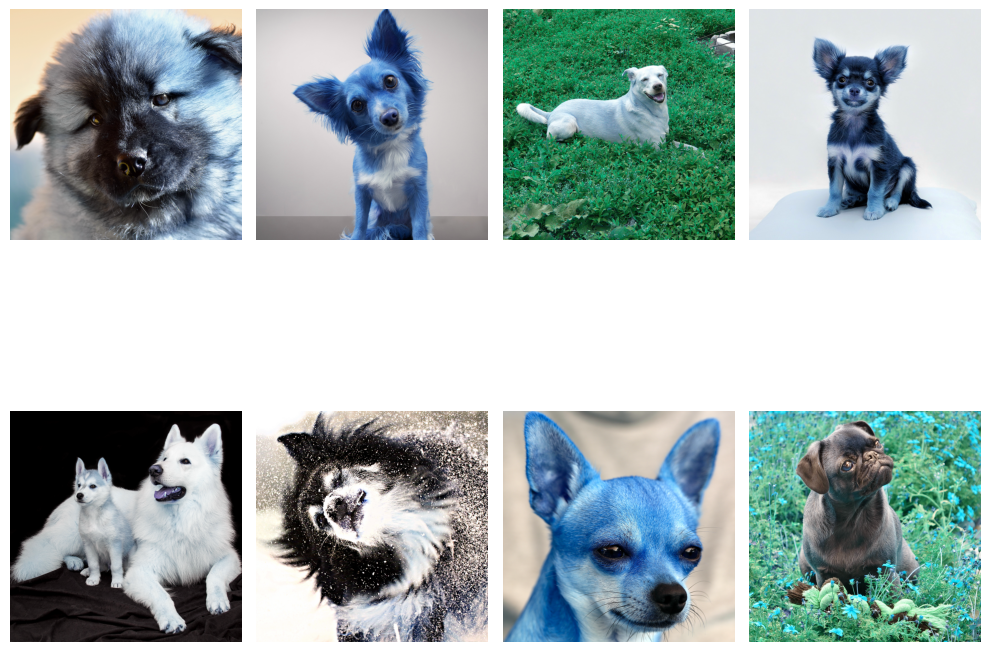

In [107]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images2):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("/kaggle/input/new-data-set-123/dogvscat/train/dog", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

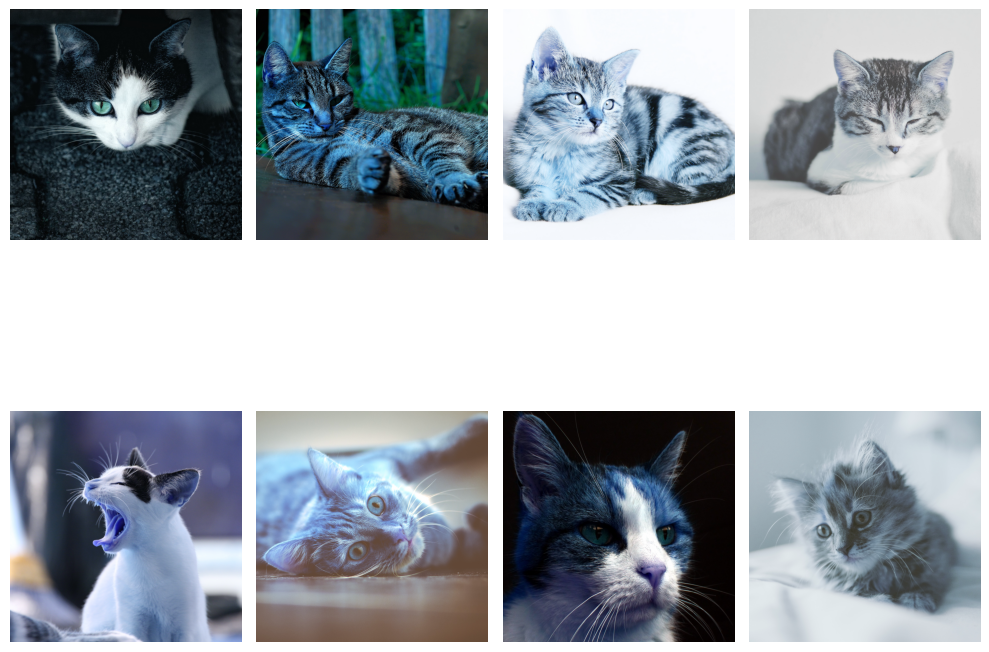

In [109]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images2):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("/kaggle/input/new-data-set-123/dogvscat/train/cat", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

# ****MobileNetV2 Modeling

In [110]:
#Code by 'Real vs Fake face detection' https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

9406464/9406464 [==============================] - 1s 0us/step


In [111]:
#Code by 'Real vs Fake face detection' https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "ReLU"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "ReLU"),
                    Dropout(0.1),
                    Dense(32, activation = "ReLU"),
                    Dropout(0.3),
                    Dense(2, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [112]:
#Code by 'Real vs Fake face detection' https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Training

In [113]:
EPOCHS = 20
hist = model.fit(xtrain, ytrain, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=(xval,yval))

Epoch 1/20
13/13 [==============================] - 8s 216ms/step - loss: 0.2866 - accuracy: 0.8650 - val_loss: 0.3736 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - 1s 41ms/step - loss: 0.0485 - accuracy: 0.9775 - val_loss: 0.2803 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - 1s 42ms/step - loss: 0.0191 - accuracy: 0.9950 - val_loss: 0.3822 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - 1s 44ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.2701 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/20
13/13 [==============================] - 1s 41ms/step - loss: 0.0185 - accuracy: 0.9925 - val_loss: 0.1697 - val_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 6/20
13/13 [==============================] - 1s 42ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.1107 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 7/20
13/13 [==============================] - 1s 41ms/ste

# Visualising the accuracy and loss

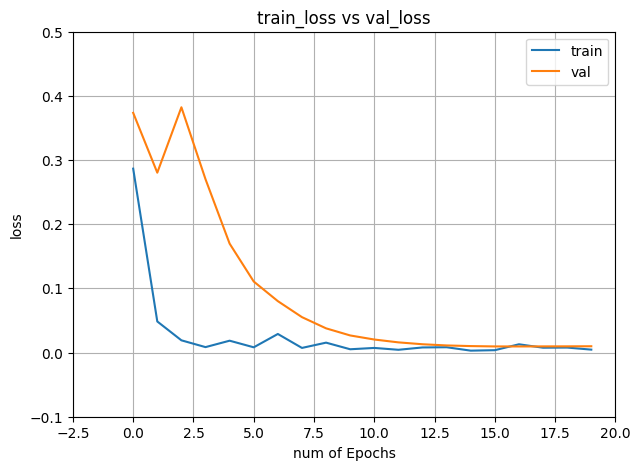

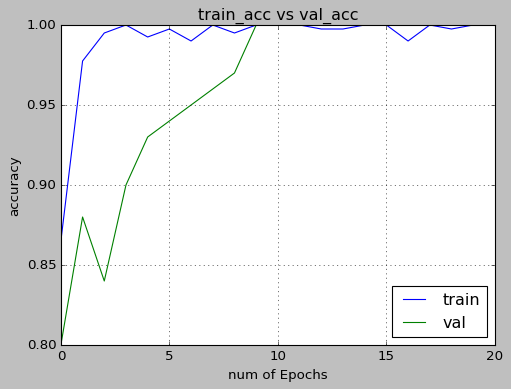

In [115]:

epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


# Testing

In [116]:
def predict(img_name, model):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)
    prediction=model.predict(img.reshape(1,224,224,3))
    output=np.argmax(prediction)
    print(train_class[output])


# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

In [117]:
predictions=[]

for img in test_images:
    img=img.reshape(1,224,224,3)
    predictions.append(model.predict(img))

1/1 [==============================] - 0s 21ms/step


In [118]:
pred_labels = model.predict(test_images)

2/2 [==============================] - 1s 666ms/step


In [119]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_image_label, pred_labels, target_names=test_class))

              precision    recall  f1-score   support

         dog       1.00      0.96      0.98        25
         cat       0.96      1.00      0.98        25

   micro avg       0.98      0.98      0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50
 samples avg       0.98      0.98      0.98        50



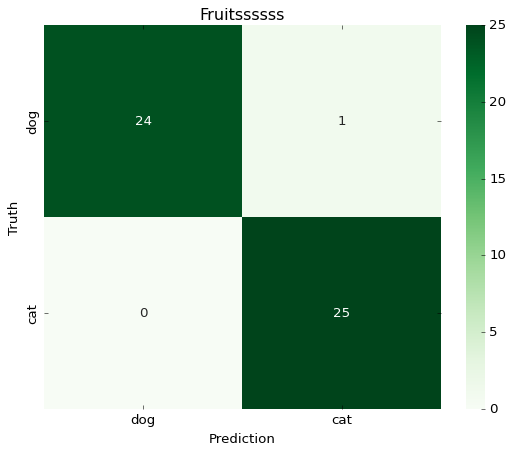

In [120]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_image_label, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class,
                yticklabels=test_class)

plt.title('Fruitssssss')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

# Sample Prediction

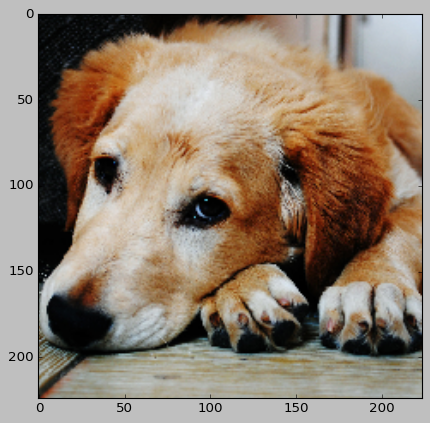

1/1 [==============================] - 0s 21ms/step
dog


In [122]:
predict("/kaggle/input/new-data-set-123/dogvscat/train/dog/0.jpg",model)

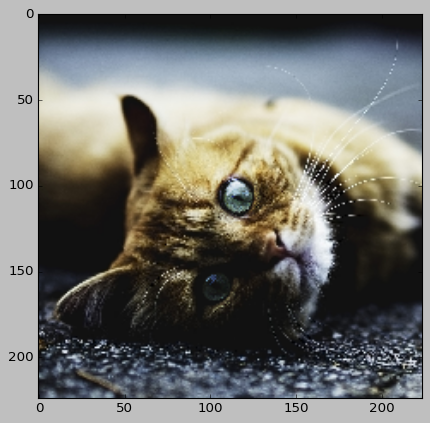

1/1 [==============================] - 0s 22ms/step
cat


In [123]:
predict("/kaggle/input/new-data-set-123/dogvscat/train/cat/0.jpg",model)

In [125]:
model.save('model.h5')